In [1]:
import IJulia
import Base64

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = "L3J1bi9tZWRpYS9hbGYvZGF0b3MvbWlzcmVwb3NpdG9yaW9zL2RvY2VuY2lhL2FwcmVuZGl6YWplLWF1dG9tYXRpY28tcHJhY3RpY2FzLWp1bGlh"
  if !isempty(run_path)
    run_path = String(Base64.base64decode(run_path))
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
function fibonacci(n::Int)
    a = zeros(Float32, n)
    a[1] = 1
    a[2] = 1
    for i in 3:n
        a[i] = a[i-1] + a[i-2]
    end
    return a
end

fibonacci (generic function with 1 method)

In [3]:
fib = fibonacci(25) 
tamaño = 4
n = 25 - tamaño
# La red esperar una entrada con dimensiones (características, tamaño, lote).
X =  Array{Float32}(undef, 1, tamaño, n)
Y = Array{Float32}(undef, 1, n)  
for i = 1:n
    ventana = fib[i:i+tamaño-1]
    etiqueta = fib[i+tamaño]
    X[1, : , i] .= ventana
    Y[1, i] = etiqueta
end

In [4]:
using Lux, Random

modelo = Chain(
    Recurrence(RNNCell(1 => 1, identity; use_bias = false); return_sequence = false)
)

rng = Random.default_rng()
ps, st = Lux.setup(rng, modelo)

((layer_1 = (weight_ih = Float32[-1.8113784;;], weight_hh = Float32[-1.4741229;;]),), (layer_1 = (rng = TaskLocalRNG(),),))

In [5]:
using Statistics
function coste(ps, st, X, Y)
    ŷ, estado = modelo(X, ps, st)          # ŷ: (1, batch)
    return mean((ŷ .- Y).^2)
end

coste(ps, st, X, Y)

6.061412f8

In [6]:
using Optimisers, Zygote
opt = Optimisers.setup(Optimisers.Adam(0.1f0), ps)

nepocas = 200
costes = []
for epoca in 1:nepocas
    # gradiente de la red con respecto a los parámetros
    gs = first(Zygote.gradient(p -> coste(p, st, X, Y), ps))
    opt, ps = Optimisers.update(opt, ps, gs) 
    push!(costes, coste(ps, st, X, Y))
    println("Época $epoca | coste = ", costes[end])
end

Época 1 | coste = 4.8350666e8


Época 2 | coste = 3.735187e8
Época 3 | coste = 2.726197e8
Época 4 | coste = 1.7626586e8
Época 5 | coste = 8.8890776e7
Época 6 | coste = 2.3921978e7
Época 7 | coste = 56692.168
Época 8 | coste = 2.8856764e7
Época 9 | coste = 8.230882e7
Época 10 | coste = 1.0871741e8
Época 11 | coste = 9.568808e7
Época 12 | coste = 6.161932e7
Época 13 | coste = 2.780911e7
Época 14 | coste = 6.4904535e6
Época 15 | coste = 226.3438
Época 16 | coste = 4.510433e6
Época 17 | coste = 1.4312293e7
Época 18 | coste = 2.4547382e7
Época 19 | coste = 3.2128372e7
Época 20 | coste = 3.560642e7
Época 21 | coste = 3.4733824e7
Época 22 | coste = 3.0087132e7
Época 23 | coste = 2.2822792e7
Época 24 | coste = 1.4504687e7
Época 25 | coste = 6.907716e6
Época 26 | coste = 1.7048375e6
Época 27 | coste = 4053.34
Época 28 | coste = 1.842089e6
Época 29 | coste = 5.9404525e6
Época 30 | coste = 1.0095086e7
Época 31 | coste = 1.2218685e7
Época 32 | coste = 1.1418784e7
Época 33 | coste = 8.323184e6
Época 34 | coste = 4.491537e6
Época

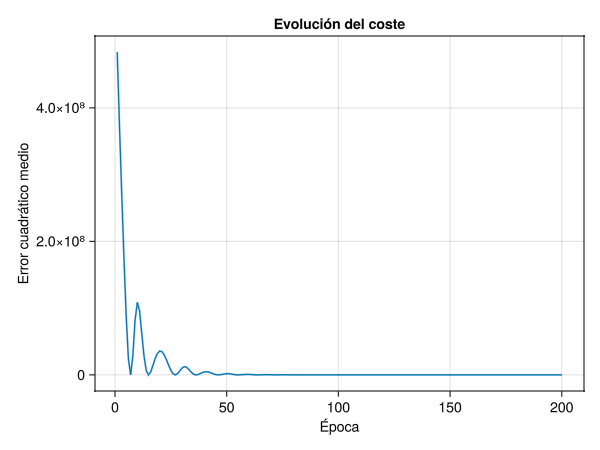

In [7]:
using GLMakie
fig = Figure()
ax = Axis(fig[1, 1], xlabel = "Época", ylabel = "Error cuadrático medio", title = "Evolución del coste")
lines!(ax, costes)
fig

In [8]:
fib = fibonacci(30)
X_test = reshape(fib[end-tamaño : end-1], 1, tamaño, 1) 

y_test, _ = modelo(X_test, ps, st)
println("Predicción del término 30: ",  y_test[1, 1])
println("Término 30 de la sucesión de Fibonacci: ", fib[end])

Predicción del término 30: 832036.3
Término 30 de la sucesión de Fibonacci: 832040.0


In [9]:
println("Pesos de la entrada de la red neuronal:", ps.layer_1.weight_ih)
println("Pesos del estado de la red neuronal:", ps.layer_1.weight_hh)

Pesos de la entrada de la red neuronal:Float32[-1.3328574;;]
Pesos del estado de la red neuronal:Float32[-2.2770586;;]


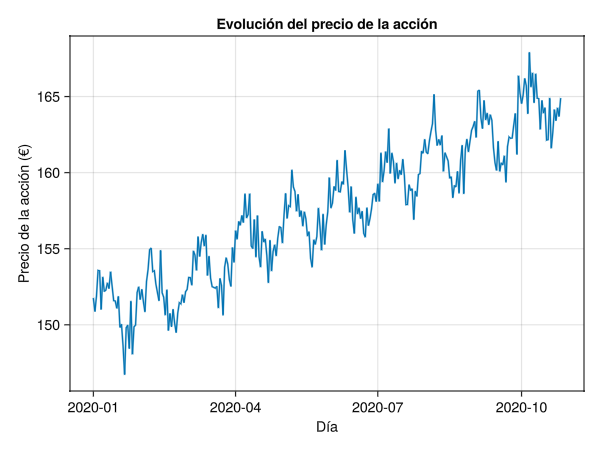

In [10]:
using CSV, DataFrames, GLMakie

# Cargamos el conjunto de datos en un data frame
df = CSV.read("datos/stock.csv", DataFrame)

# Creamos el gráfico de la evolución
fig = Figure()
ax = Axis(fig[1, 1], xlabel = "Día", ylabel = "Precio de la acción (€)", title = "Evolución del precio de la acción")

lines!(ax, df.dia, df.precio)
fig

In [11]:
using Statistics

# Simple normalization (z-score)
μ = mean(df.precio)
σ = std(df.precio)
serie = (df.precio .- μ) ./ σ     

300-element Vector{Float64}:
 -1.2770239698472932
 -1.4749432268197025
 -1.2481144154580652
 -0.8745140202741842
 -0.8789616440263692
 -1.4460336724304748
 -0.9679141190701513
 -1.1814000591752272
 -1.1591619404142832
 -1.054642782237841
 -1.1391476335294317
 -0.8923045152829369
 -1.1035666435119202
  ⋮
  1.4249074596075517
  1.5049646871469575
  1.031292757538819
  1.0379641931671029
  1.6472886472170039
  0.9112069162297167
  1.1469309750957366
  1.4782789446338223
  1.3137168658028255
  1.5027408752708586
  1.3759835983334725
  1.6450648353409114

In [12]:
function crear_secuencias(serie, tamaño)
    # Número de ventanas
    n = length(serie) - tamaño  

    # X: (características=1, tamaño=seq_len, lotes=n)
    X = Array{Float32}(undef, 1, tamaño, n)
    # Y: (etiquetas=1, lotes=n)
    Y = Array{Float32}(undef, 1, n)

    for i in 1:n
        ventana = serie[i : i + tamaño - 1]
        etiqueta = serie[i + tamaño]
        X[1, :, i] .= ventana
        Y[1, i] = etiqueta
    end

    return X, Y
end

X, Y = crear_secuencias(serie, 50)

(Float32[-1.2770239 -1.4749433 … -1.7551435 -1.501629;;; -1.4749433 -1.2481145 … -1.501629 -1.6973244;;; -1.2481145 -0.87451404 … -1.6973244 -1.4393623;;; … ;;; 1.7607031 1.3515216 … 1.478279 1.3137169;;; 1.3515216 1.1980786 … 1.3137169 1.5027409;;; 1.1980786 1.6117077 … 1.5027409 1.3759836], Float32[-1.6973244 -1.4393623 … 1.3759836 1.6450648])

In [13]:
Xentrenamiento, Yentrenamiento = X[:, :, 1:200], Y[:, 1:200]
Xtest, Ytest = X[:, :, 201:end], Y[:, 201:end]

(Float32[0.08839652 0.09062033 … 1.3515216 1.1980786;;; 0.09062033 0.3797159 … 1.1980786 1.6117077;;; 0.3797159 0.29298723 … 1.6117077 1.3248359;;; … ;;; 1.7607031 1.3515216 … 1.478279 1.3137169;;; 1.3515216 1.1980786 … 1.3137169 1.5027409;;; 1.1980786 1.6117077 … 1.5027409 1.3759836], Float32[1.6117077 1.3248359 … 1.3759836 1.6450648])

In [14]:
using Lux, Random
modelo = Chain(
    Recurrence(RNNCell(1 => 32); return_sequence = false),
    Dense(32 => 1)
)

rng = Random.default_rng()
Random.seed!(rng, 123)
ps, st = Lux.setup(rng, modelo)

((layer_1 = (weight_ih = Float32[-0.40507698; -0.69411415; … ; -0.0055406666; -0.24833952;;], weight_hh = Float32[-0.56152004 -0.35429007 … -0.034519292 0.029836513; 0.07203944 -0.34725466 … -0.14517684 -0.102405354; … ; -0.4274054 -0.08432662 … 0.15626785 0.017901242; 0.367459 -0.024751991 … -0.98040897 -0.08634019], bias_ih = Float32[-0.44443923, 0.03844804, -0.38237762, -0.5595606, 0.014967673, -0.06697602, -0.71157426, -0.6767735, -0.050807025, -0.41618267  …  -0.00027102532, 0.05049654, -0.9198266, -0.47244, -0.3064167, 0.7760633, 0.13779616, -0.10556045, -0.40396777, 0.19834644], bias_hh = Float32[0.20496586, -0.6226694, -0.24629952, -0.19513933, 0.20913823, -0.38392618, -0.75015336, 0.26386532, 0.013880453, -0.25140664  …  0.17191038, 0.16226642, 0.0011014869, -0.29639533, -0.029293913, -0.3869417, 1.1573281, 0.063846156, -0.11788625, 0.07993953]), layer_2 = (weight = Float32[-0.22283314 -0.2129307 … -0.25660995 -0.109234825], bias = Float32[-0.05496811])), (layer_1 = (rng = Tas

In [15]:
using Statistics
function coste(ps, st, X, Y)
    ŷ, estado = modelo(X, ps, st)
    return mean((ŷ .- Y).^2)
end

coste(ps, st, X, Y)

4.5342793f0

In [16]:
using Optimisers, Zygote
opt = Optimisers.setup(Optimisers.Adam(0.01f0), ps)

nepocas = 300
costes = []
for epoca in 1:nepocas
    # gradiente de la red con respecto a los parámetros
    gs = first(Zygote.gradient(p -> coste(p, st, Xentrenamiento, Yentrenamiento), ps))
    opt, ps = Optimisers.update(opt, ps, gs) 
    push!(costes, coste(ps, st, Xentrenamiento, Yentrenamiento))
    println("Época $epoca | coste = ", costes[end])
end

Época 1 | coste = 2.1700213


Época 2 | coste = 1.2904681
Época 3 | coste = 0.75347173
Época 4 | coste = 

0.5323743
Época 5 | coste = 0.5359257
Época 6 | coste = 0.6563437
Época 7 | coste = 0.7999661
Época 8 | coste = 0.90940547
Época 9 | coste = 0.95519793
Época 10 | coste = 0.9289719
Época 11 | coste = 0.8561282
Época 12 | coste = 

0.76295495
Época 13 | coste = 0.6699936
Época 14 | coste = 0.5879053
Época 15 | coste = 0.5317313
Época 16 | coste = 0.50571895
Época 17 | coste = 0.49636975
Época 18 | coste = 0.49457246
Época 19 | coste = 0.48322526
Época 20 | coste = 

0.44700664
Época 21 | coste = 0.3985928
Época 22 | coste = 0.4427828
Época 23 | coste = 0.44108185
Época 24 | coste = 0.4221953
Época 25 | coste = 0.40475628
Época 26 | coste = 0.38810498
Época 27 | coste = 0.37025496
Época 28 | coste = 0.3461993
Época 29 | coste = 0.31766117
Época 30 | coste = 0.27511552
Época 31 | coste = 0.23719025
Época 32 | coste = 0.23396589
Época 33 | coste = 0.21911442
Época 34 | coste = 0.17911388
Época 35 | coste = 0.14789844
Época 36 | coste = 0.14183117
Época 37 | coste = 0.1447025
Época 38 | coste = 0.13877447
Época 39 | coste = 0.12388421
Época 40 | coste = 0.10673165
Época 41 | coste = 0.09850201
Época 42 | coste = 

0.102619246
Época 43 | coste = 0.101413146
Época 44 | coste = 0.0923995
Época 45 | coste = 0.08354571
Época 46 | coste = 0.081332095
Época 47 | coste = 0.083627775
Época 48 | coste = 0.08280305
Época 49 | coste = 0.08143177
Época 50 | coste = 0.08029093
Época 51 | coste = 0.0807796
Época 52 | coste = 0.079484254
Época 53 | coste = 0.077951305
Época 54 | coste = 0.075300306
Época 55 | coste = 0.07474201
Época 56 | coste = 0.074464135
Época 57 | coste = 0.07230858
Época 58 | coste = 0.07325814
Época 59 | coste = 0.07381306
Época 60 | coste = 0.07364072
Época 61 | coste = 0.0727028
Época 62 | coste = 0.07207622
Época 63 | coste = 0.07216211
Época 64 | coste = 

0.07264301
Época 65 | coste = 0.07221163
Época 66 | coste = 0.07150847
Época 67 | coste = 0.07151537
Época 68 | coste = 0.07144897
Época 69 | coste = 0.0712092
Época 70 | coste = 0.070581764
Época 71 | coste = 0.06985798
Época 72 | coste = 0.069736
Época 73 | coste = 0.069666766
Época 74 | coste = 0.06955662
Época 75 | coste = 0.06941067
Época 76 | coste = 0.06923559
Época 77 | coste = 0.06914187
Época 78 | coste = 0.06914664
Época 79 | coste = 0.06900422
Época 80 | coste = 0.06887253
Época 81 | coste = 0.06866732
Época 82 | coste = 0.068438485
Época 83 | coste = 0.06832708
Época 84 | coste = 0.068140805
Época 85 | coste = 0.06802712


Época 86 | coste = 0.06803582
Época 87 | coste = 0.06799295
Época 88 | coste = 0.06777685
Época 89 | coste = 0.06752043
Época 90 | coste = 0.06742681
Época 91 | coste = 0.06737441
Época 92 | coste = 0.06724757
Época 93 | coste = 0.06704515
Época 94 | coste = 0.06696045
Época 95 | coste = 0.066884354
Época 96 | coste = 0.066817015
Época 97 | coste = 0.06683132
Época 98 | coste = 0.066623844
Época 99 | coste = 0.066462725
Época 100 | coste = 0.06633864
Época 101 | coste = 0.06622588
Época 102 | coste = 0.06609246
Época 103 | coste = 0.06596448
Época 104 | coste = 0.065785594
Época 105 | coste = 0.06559823
Época 106 | coste = 

0.06545346
Época 107 | coste = 0.065274686
Época 108 | coste = 0.06506727
Época 109 | coste = 0.064891465
Época 110 | coste = 0.06469418
Época 111 | coste = 0.064517155
Época 112 | coste = 0.064328
Época 113 | coste = 0.064112246
Época 114 | coste = 0.063915804
Época 115 | coste = 0.063712485
Época 116 | coste = 0.06334854
Época 117 | coste = 0.0633842
Época 118 | coste = 0.06334936
Época 119 | coste = 0.06310195
Época 120 | coste = 0.062810294
Época 121 | coste = 0.06274862
Época 122 | coste = 0.062039703
Época 123 | coste = 0.061746158
Época 124 | coste = 0.061886244
Época 125 | coste = 0.061414238
Época 126 | coste = 0.06090387
Época 127 | coste = 0.06077025


Época 128 | coste = 0.060291108
Época 129 | coste = 0.06059688
Época 130 | coste = 0.06033463
Época 131 | coste = 0.0595562
Época 132 | coste = 0.05905487
Época 133 | coste = 0.059523873
Época 134 | coste = 0.05900393
Época 135 | coste = 0.059820436
Época 136 | coste = 0.059423655
Época 137 | coste = 0.06087105
Época 138 | coste = 0.060820524
Época 139 | coste = 0.059448753
Época 140 | coste = 0.059891257
Época 141 | coste = 0.060466465
Época 142 | coste = 0.06169413
Época 143 | coste = 0.059938546
Época 144 | coste = 0.060918078
Época 145 | coste = 0.062549375
Época 146 | coste = 0.05976898
Época 147 | coste = 0.059949454
Época 148 | coste = 

0.06020357
Época 149 | coste = 0.059262305
Época 150 | coste = 0.05745561
Época 151 | coste = 0.062461007
Época 152 | coste = 0.061310407
Época 153 | coste = 0.06333496
Época 154 | coste = 0.063313805
Época 155 | coste = 0.06169313
Época 156 | coste = 0.062480688
Época 157 | coste = 0.07096082
Época 158 | coste = 0.08216053
Época 159 | coste = 0.08303716
Época 160 | coste = 0.07931856
Época 161 | coste = 0.076634146
Época 162 | coste = 0.07600107
Época 163 | coste = 0.07786248
Época 164 | coste = 0.08091953
Época 165 | coste = 0.08151956
Época 166 | coste = 0.07955838
Época 167 | coste = 0.076931365
Época 168 | coste = 0.07470631
Época 169 | coste = 0.07283295
Época 170 | coste = 

0.07100605
Época 171 | coste = 0.06922025
Época 172 | coste = 0.06773627
Época 173 | coste = 0.0667912
Época 174 | coste = 0.06640302
Época 175 | coste = 0.06581214
Época 176 | coste = 0.06614189
Época 177 | coste = 0.06628107
Época 178 | coste = 0.066499665
Época 179 | coste = 0.06651368
Época 180 | coste = 0.06633793
Época 181 | coste = 0.0663129
Época 182 | coste = 0.066097334
Época 183 | coste = 0.06580397
Época 184 | coste = 0.0653358
Época 185 | coste = 0.06591179
Época 186 | coste = 0.067203104
Época 187 | coste = 0.06631997
Época 188 | coste = 0.06649982
Época 189 | coste = 0.06603855
Época 190 | coste = 0.06612165
Época 191 | coste = 0.06537511
Época 192 | coste = 

0.06465734
Época 193 | coste = 0.06555025
Época 194 | coste = 0.0667412
Época 195 | coste = 0.067740485
Época 196 | coste = 0.067047246
Época 197 | coste = 0.068030015
Época 198 | coste = 0.0687395
Época 199 | coste = 0.067789234
Época 200 | coste = 0.06808305
Época 201 | coste = 0.06796386
Época 202 | coste = 0.0671582
Época 203 | coste = 0.0666399
Época 204 | coste = 0.06635813
Época 205 | coste = 0.06607883
Época 206 | coste = 0.065261915
Época 207 | coste = 0.06474862
Época 208 | coste = 0.06440013
Época 209 | coste = 0.06393309
Época 210 | coste = 0.06397327
Época 211 | coste = 0.06361207
Época 212 | coste = 0.06317264
Época 213 | coste = 0.06374191


Época 214 | coste = 0.066123456
Época 215 | coste = 0.06568557
Época 216 | coste = 0.06531642
Época 217 | coste = 0.06496945
Época 218 | coste = 0.064629085
Época 219 | coste = 0.06428939
Época 220 | coste = 0.06407333
Época 221 | coste = 0.06384997
Época 222 | coste = 0.06401357
Época 223 | coste = 0.063782394
Época 224 | coste = 0.06354766
Época 225 | coste = 0.06334236
Época 226 | coste = 0.06336849
Época 227 | coste = 0.0631208
Época 228 | coste = 0.06289776
Época 229 | coste = 0.06262077
Época 230 | coste = 0.06244329
Época 231 | coste = 0.062286414
Época 232 | coste = 0.062150866
Época 233 | coste = 0.06200399
Época 234 | coste = 

0.06183406
Época 235 | coste = 0.06165925
Época 236 | coste = 0.0614862
Época 237 | coste = 0.061334923
Época 238 | coste = 0.06112329
Época 239 | coste = 0.061425664
Época 240 | coste = 0.061252046
Época 241 | coste = 0.061051454
Época 242 | coste = 0.060874943
Época 243 | coste = 0.060400248
Época 244 | coste = 0.060241256
Época 245 | coste = 0.060103778
Época 246 | coste = 0.059968766
Época 247 | coste = 0.0597995
Época 248 | coste = 0.059598185
Época 249 | coste = 0.059431348
Época 250 | coste = 0.059263848
Época 251 | coste = 0.05909176
Época 252 | coste = 0.05892838
Época 253 | coste = 0.05876087
Época 254 | coste = 0.05875407
Época 255 | coste = 0.060250282


Época 256 | coste = 0.061521392
Época 257 | coste = 0.06165414
Época 258 | coste = 0.06201637
Época 259 | coste = 0.061379634
Época 260 | coste = 0.06027026
Época 261 | coste = 0.06022252
Época 262 | coste = 0.06043122
Época 263 | coste = 0.05900131
Época 264 | coste = 0.05900708
Época 265 | coste = 0.059419125
Época 266 | coste = 0.05855721
Época 267 | coste = 0.05874944
Época 268 | coste = 0.057821583
Época 269 | coste = 0.056702863
Época 270 | coste = 0.056544494
Época 271 | coste = 0.057482257
Época 272 | coste = 0.05725204
Época 273 | coste = 0.057396833
Época 274 | coste = 0.057374787
Época 275 | coste = 0.057403278
Época 276 | coste = 

0.057661675
Época 277 | coste = 0.058265124
Época 278 | coste = 0.058184933
Época 279 | coste = 0.0579613
Época 280 | coste = 0.058778707
Época 281 | coste = 0.058199696
Época 282 | coste = 0.058372423
Época 283 | coste = 0.05923482
Época 284 | coste = 0.060364712
Época 285 | coste = 0.06007223
Época 286 | coste = 0.060346115
Época 287 | coste = 0.059283372
Época 288 | coste = 0.05886229
Época 289 | coste = 0.06047029
Época 290 | coste = 0.06217183
Época 291 | coste = 0.058873348
Época 292 | coste = 0.060403086
Época 293 | coste = 0.061007205
Época 294 | coste = 0.060288668
Época 295 | coste = 0.05896577
Época 296 | coste = 0.059117425
Época 297 | coste = 0.05901834
Época 298 | coste = 

0.05808721
Época 299 | coste = 0.058174625
Época 300 | coste = 0.058059283


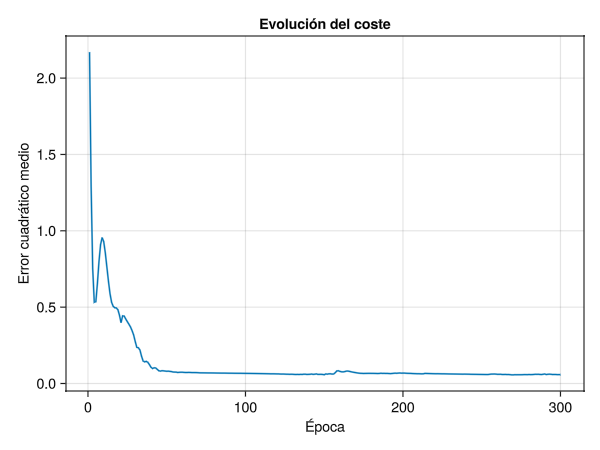

In [17]:
using GLMakie
fig = Figure()
ax = Axis(fig[1, 1], xlabel = "Época", ylabel = "Error cuadrático medio", title = "Evolución del coste")
lines!(ax, costes)
fig

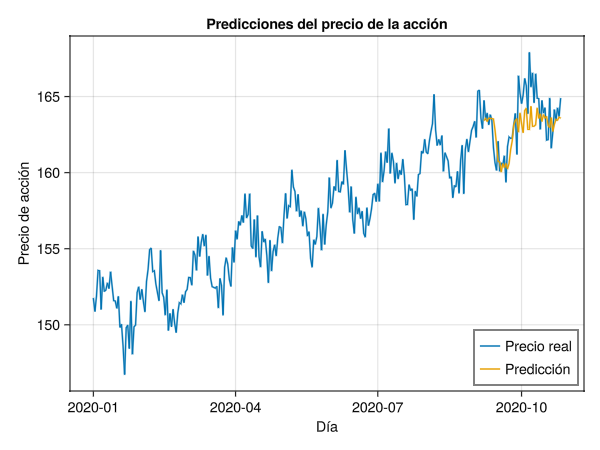

In [18]:
y_test, _ = modelo(Xtest, ps, st)
predicciones = y_test .* σ .+ μ

fig = Figure()
ax = Axis(fig[1,1], xlabel = "Día", ylabel = "Precio de acción", title = "Predicciones del precio de la acción")
lines!(ax, df.dia, df.precio, label = "Precio real")
lines!(ax, df.dia[251:end], vec(predicciones), label = "Predicción")
axislegend(ax, position = :rb)
fig